In [153]:
import casadi as ca
import numpy as np
import pandas as pd
from pytope import Polytope
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

In [154]:
nu = 2
N_Sam = 10
n_generator = 3

random_vals = np.random.uniform(-1, 1, size=(nu,N_Sam))
print(random_vals)

[[ 0.94693146 -0.4130823  -0.14943128 -0.38066963  0.23476696 -0.29361696
  -0.52434547  0.01180951  0.05560925  0.71256566]
 [-0.90252488 -0.36209858 -0.27535927 -0.13035291  0.04574583  0.76955446
   0.35869688 -0.71544555 -0.97920148  0.56860808]]


In [155]:
data_id = "28"
background_filepath = f"./inD-dataset-v1.1/data/{data_id}_background.png"
recordingMeta_filepath = f"./inD-dataset-v1.1/data/{data_id}_recordingMeta.csv"
tracks_filepath = f"./inD-dataset-v1.1/data/{data_id}_tracks.csv"
tracksMeta_filepath = f"./inD-dataset-v1.1/data/{data_id}_tracksMeta.csv"

In [156]:
tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == 79]
# print(type(filtered_data['xAcceleration']))
# print(filtered_data['xAcceleration'].to_numpy())

In [157]:
def opti_zono():
    opti = ca.Opti()

    c = opti.variable(nu,1)
    g = opti.variable(nu,n_generator)
    lam = opti.variable(n_generator,N_Sam)

    samples = opti.parameter(nu,N_Sam)

    g_size = ca.trace(g.T @ g)
    opti.minimize(g_size)

    for i in range(N_Sam):
        opti.subject_to(samples[:,i] == c + g@lam[:,i])

    opti.subject_to(opti.bounded(-1, lam, 1))
    for i in range(nu):
        opti.subject_to(ca.fabs(g[i]) > 1e-6)

    opts = {"ipopt.print_level": 0, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f', [samples], [c, g, lam]) 

In [158]:
f = opti_zono()
c_hat, g_hat,lam_hat = f(random_vals)
print(c_hat, g_hat,lam_hat)

[-0.00828628, -0.162684] 
[[0, 0, 0], 
 [0, 0, 0]] 
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [159]:
print(c_hat[0])

-0.00828628


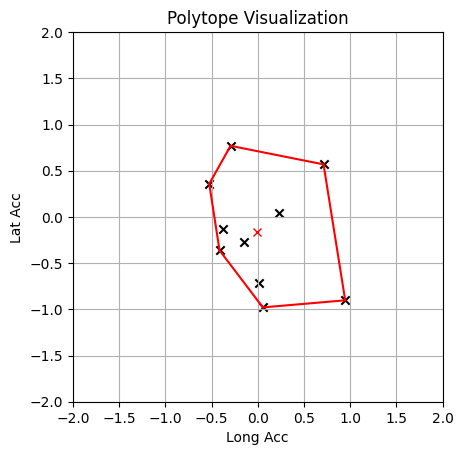

In [160]:
plt.figure()

#sample points
plt.scatter(random_vals[0,:],random_vals[1,:],marker='x',color = 'black')

#y
plt.plot(c_hat[0], c_hat[1], marker='x',color='red')

#convexhull
points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Polytope Visualization")
plt.xlabel("Long Acc")
plt.ylabel("Lat Acc")
plt.grid(True)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

Zonotope Center: [1.6 1.4]
Generators (Axis-Aligned):
 [[1. 0.]
 [0. 1.]]
Bounds (Scaling Factors): [1.5 1.5]


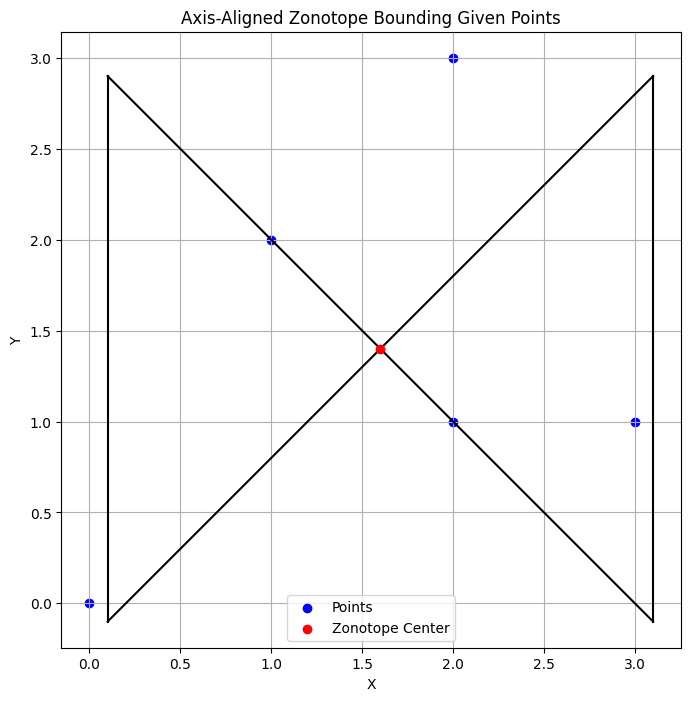

In [161]:
import numpy as np
import matplotlib.pyplot as plt

def compute_axis_aligned_zonotope(points):
    """
    Computes an axis-aligned zonotope that bounds the given points.

    Parameters:
        points (ndarray): An (n x d) array of n points in d-dimensional space.

    Returns:
        center (ndarray): The center of the zonotope.
        generators (ndarray): The generator vectors of the zonotope.
        bounds (list): Scaling factors for each generator.
    """
    # Compute the center of the zonotope
    center = np.mean(points, axis=0)
    
    # Compute bounds along each axis
    min_vals = np.min(points, axis=0)
    max_vals = np.max(points, axis=0)
    bounds = (max_vals - min_vals) / 2.0
    
    # Generators are axis-aligned
    generators = np.eye(points.shape[1])
    
    return center, generators, bounds

def plot_axis_aligned_zonotope(points, center, generators, bounds):
    """
    Plots the points and the axis-aligned zonotope.

    Parameters:
        points (ndarray): The original points.
        center (ndarray): The center of the zonotope.
        generators (ndarray): The generator vectors of the zonotope.
        bounds (list): Scaling factors for the generators.
    """
    # Generate the zonotope vertices using axis-aligned generators
    vertices = []
    for sign1 in [-1, 1]:
        for sign2 in [-1, 1]:
            vertex = center + sign1 * bounds[0] * generators[0] + sign2 * bounds[1] * generators[1]
            vertices.append(vertex)
    vertices = np.array(vertices)
    
    # Plot the points
    plt.figure(figsize=(8, 8))
    plt.scatter(points[:, 0], points[:, 1], color='blue', label='Points')
    plt.scatter(center[0], center[1], color='red', label='Zonotope Center', zorder=5)
    
    # Plot the zonotope edges
    for i in range(len(vertices)):
        plt.plot(
            [vertices[i, 0], vertices[(i+1) % 4, 0]],
            [vertices[i, 1], vertices[(i+1) % 4, 1]],
            'k-'
        )

    # Annotate
    plt.legend()
    plt.title("Axis-Aligned Zonotope Bounding Given Points")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Define some points in 2D
    points = np.array([
        [1, 2],
        [2, 3],
        [3, 1],
        [0, 0],
        [2, 1]
    ])

    # Compute the axis-aligned zonotope
    center, generators, bounds = compute_axis_aligned_zonotope(points)
    
    # Print results
    print("Zonotope Center:", center)
    print("Generators (Axis-Aligned):\n", generators)
    print("Bounds (Scaling Factors):", bounds)
    
    # Plot the zonotope
    plot_axis_aligned_zonotope(points, center, generators, bounds)
